In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()
from MLBUtils import MLBUtils
mlb_utils = MLBUtils()

%matplotlib inline

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV
cp Combined.csv ~/drive/Notes/ML/Pytorch/baseballData/

Appears to be an issue with there being one less column

In [3]:
df = pd.read_csv("./baseballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)
print(df.shape)

# MISSING ODDS DATA ARE ALREADY REMOVED 
# Remove missing odds data (This works?)
# df = df[df['D_start_odds'] != 0.0]

# Convert H_won from 0 or 1 to -1 or 1
df['H_Won'] = (df['H_Won'] * 2) - 1
# Sign represents which team won. Value represents the implied probability (1/decimal = implied)
df['combined'] = np.where(df['H_Won'] == 1, df['H_Won'] * (1 / df['H_start_odds']), df['H_Won'] * (1 / df['V_start_odds']))

df['Home_Team'] = df['Home_Team'].astype('category')
df['Visitor_Team'] = df['Visitor_Team'].astype('category')
df['Home_Team_Id'] = df['Home_Team'].cat.codes
df['Visitor_Team_Id'] = df['Visitor_Team'].cat.codes

# Retrieve original team name given a category code
home_cat_mapping = df['Home_Team'].cat.categories
home_team_from_id = lambda cat_code: home_cat_mapping[cat_code]
visitor_cat_mapping = df['Visitor_Team'].cat.categories
visitor_team_from_id = lambda cat_code: visitor_cat_mapping[cat_code]

# Remove the performance set
test_performance_size = 200
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]

df.info()


(32308, 68)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32108 entries, 0 to 32107
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unnamed: 0            32108 non-null  int64   
 1   Date                  32108 non-null  object  
 2   Home_Team             32108 non-null  category
 3   Home_Wins             32108 non-null  int64   
 4   Home_Losses           32108 non-null  int64   
 5   Visitor_Team          32108 non-null  category
 6   Visitor_Wins          32108 non-null  int64   
 7   Visitor_Losses        32108 non-null  int64   
 8   Final_Score           32108 non-null  object  
 9   Visitor_Final_Score   32108 non-null  int64   
 10  Home_Final_Score      32108 non-null  int64   
 11  Winning_Team          32108 non-null  object  
 12  Home/Victory_Win      32108 non-null  object  
 13  Game_Time             32108 non-null  object  
 14  Winning_Pitcher       32108 non-null  obje

## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [4]:
cont_cols = [
    # General
    
    # Random
    'D_AB',
    'D_R',
    'D_H',
    'D_BB',
    'D_PA',
    
    # Batting stats
    'D_SO',    # Strikeouts
    'D_BA',    # Batting Average
    'D_OBP',   # On-Base Percentage
    'D_SLG',   # Slugging Percentage
    'D_OPS',   # On-Base Plus Slugging
    'D_RBI',   # Runs Batted In
    'D_PIT',   # Pitches
    'D_STR',   # Strikes
    'D_WPA',   # Win Probability Added
    'D_aLI',   # Average Leverage Index

    # Pitching stats
    'D_P_H',   # Hits Allowed by Pitcher
    'D_P_R',   # Runs Allowed by Pitcher
    'D_ER',    # Earned Runs by Pitcher
    'D_P_BB',  # Walks by Pitcher
    'D_P_SO',  # Strikeouts by Pitcher
    'D_HR',    # Home Runs Allowed by Pitcher
    'D_ERA',   # Earned Run Average
    'D_CTCT',  # Contact Rate
    'D_STS',   # Swings and Misses (Strikes)
    'D_STL',   # Stolen Bases Against
    'D_GB',    # Ground Balls
    'D_FB',    # Fly Balls
    'D_LD',    # Line Drives
    'D_GSC',   # Game Score
    'D_P_WPA', # Pitcher Win Probability Added
    'D_P_aLI', # Pitcher Average Leverage Index

    # Odds
    'D_start_odds',

    # Calculated
    'D_pythagorean',
    
    # Remove later
    # 'D_Final_Score',
    # 'D_Final_Allowed'
]

drop_cols = [ 'D_BA', 'D_datediff', 'D_AB', 'D_P_WPA', 'D_P_H', 'D_ER', 'D_BA', 'D_ERA', 'D_SLG', 'D_H', 'D_STR' ]
y_col = ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id', 'combined']
# y_col = ['H_Won', 'H_start_odds', 'V_start_odds' ,'combined']
cont_cols = [col for col in cont_cols if col not in drop_cols]

# Create cont_df and y_df from the filtered df
cont_df = df[cont_cols]
y_df = df[y_col]


# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

print(cont_df.dtypes)
print(y_df.dtypes)

D_R              float64
D_BB             float64
D_PA             float64
D_SO             float64
D_OBP            float64
D_OPS            float64
D_RBI            float64
D_PIT            float64
D_WPA            float64
D_aLI            float64
D_P_R            float64
D_P_BB           float64
D_P_SO           float64
D_HR             float64
D_CTCT           float64
D_STS            float64
D_STL            float64
D_GB             float64
D_FB             float64
D_LD             float64
D_GSC            float64
D_P_aLI          float64
D_start_odds     float64
D_pythagorean    float64
dtype: object
H_Won              float64
H_start_odds       float64
V_start_odds       float64
Home_Team_Id          int8
Visitor_Team_Id       int8
combined           float64
dtype: object


### Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [5]:
# The column headers no longer match cont_cols b/c normalization
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

In [6]:
cont_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32108 entries, 0 to 32107
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   D_R            32108 non-null  float64
 1   D_BB           32108 non-null  float64
 2   D_PA           32108 non-null  float64
 3   D_SO           32108 non-null  float64
 4   D_OBP          32108 non-null  float64
 5   D_OPS          32108 non-null  float64
 6   D_RBI          32108 non-null  float64
 7   D_PIT          32108 non-null  float64
 8   D_WPA          32108 non-null  float64
 9   D_aLI          32108 non-null  float64
 10  D_P_R          32108 non-null  float64
 11  D_P_BB         32108 non-null  float64
 12  D_P_SO         32108 non-null  float64
 13  D_HR           32108 non-null  float64
 14  D_CTCT         32108 non-null  float64
 15  D_STS          32108 non-null  float64
 16  D_STL          32108 non-null  float64
 17  D_GB           32108 non-null  float64
 18  D_FB  

In [7]:
def convert_probas(probas, local_y_col):
    """
    Using y_col, this converts 2d array of probas into a format that works with the backtest calculation.
    That is, 
    
    probas: 2d array with first element being predicted visitor odds & other being predicted home odds
    y_col: ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id', 'combined']
    """
    # Convert to decimal odds, apply 5% vig estimate
    local_y_col[:,1] = (1 / local_y_col[:,1]) / 1.05
    local_y_col[:,2] = (1 / local_y_col[:,2]) / 1.05
    # probas[:,1] = (1 / probas[:,1])
    # probas[:,0] = (1 / probas[:,0])
    
    # Set to 0 if < the model's implied probability
    bet_res = []
    for i in range(len(probas)):
        if probas[i,1] > local_y_col[i,1]:
            bet_res.append(probas[i,1]) # Convert back to decimal odds
        elif probas[i,0] > local_y_col[i,2]:
            bet_res.append((-1*probas[i,0])) # Convert back to decimal odds
        else:
            bet_res.append(0)
    return np.array(bet_res)

# Using XGBoost

In [8]:
# Fit the model
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],          # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}
aparam_grid = {
    'learning_rate': [0.005, 0.01, 0.05],        # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3],                         # Simplified to 3 values, covering shallow to deep
    'n_estimators': [300, 350, 400],             # Removed extremes, these are most common sweet spots
    'subsample': [0.5, 0.6, 0.7],                # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.5, 0.6, 0.7],         # Same as above
    'min_child_weight': [3, 4],                  # Removed 5 as it might be too restrictive
}

# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBRegressor(objective='reg:squarederror')

# Create a custom scorer using the F1 score
# f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
# grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
# grid_search.fit(conts_train, y_train[:,0])


In [9]:
#print(grid_search.best_params_)
# {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

model = XGBRegressor(
    objective='reg:squarederror',
    **{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
)
model.fit(
    conts_train,
    y_train[:,0],
    eval_set=[(conts_train,y_train[:,0])],
    verbose=True
)
probas = model.predict(perf_conts)


[0]	validation_0-rmse:0.99627
[1]	validation_0-rmse:0.99529
[2]	validation_0-rmse:0.99438
[3]	validation_0-rmse:0.99352
[4]	validation_0-rmse:0.99268
[5]	validation_0-rmse:0.99188
[6]	validation_0-rmse:0.99115
[7]	validation_0-rmse:0.99046
[8]	validation_0-rmse:0.98979
[9]	validation_0-rmse:0.98918
[10]	validation_0-rmse:0.98858
[11]	validation_0-rmse:0.98802
[12]	validation_0-rmse:0.98751
[13]	validation_0-rmse:0.98701
[14]	validation_0-rmse:0.98655
[15]	validation_0-rmse:0.98613
[16]	validation_0-rmse:0.98570
[17]	validation_0-rmse:0.98529
[18]	validation_0-rmse:0.98492
[19]	validation_0-rmse:0.98458
[20]	validation_0-rmse:0.98424
[21]	validation_0-rmse:0.98394
[22]	validation_0-rmse:0.98363
[23]	validation_0-rmse:0.98334
[24]	validation_0-rmse:0.98309
[25]	validation_0-rmse:0.98283
[26]	validation_0-rmse:0.98259
[27]	validation_0-rmse:0.98237
[28]	validation_0-rmse:0.98215
[29]	validation_0-rmse:0.98194
[30]	validation_0-rmse:0.98173
[31]	validation_0-rmse:0.98153
[32]	validation_0-

In [10]:
print(probas)

[ 0.18662879  0.04028755  0.03348066 -0.12218849  0.18272276  0.20978849
 -0.1720741  -0.02179023  0.13420674 -0.02084783  0.35737988 -0.14775014
 -0.21504411  0.19020817  0.12910642 -0.16301423  0.44724467  0.1391771
 -0.01882071 -0.14205751  0.03652416 -0.02604743  0.18079941  0.12598112
 -0.2563501  -0.01501354 -0.14935271 -0.02196897 -0.13780473 -0.14489295
 -0.01604746  0.43685263  0.00472726  0.11897615 -0.02156095 -0.2895234
  0.07316053  0.13215658  0.12362484  0.18452801 -0.03391587  0.05030754
  0.06211523 -0.14716804 -0.14861491 -0.16153108 -0.0100892   0.00054973
 -0.15470429  0.1872504  -0.20392768  0.15708156 -0.22337419  0.11101612
  0.11776172  0.13737689  0.07035029 -0.0111058  -0.14462496 -0.15735182
  0.1780705  -0.34584576  0.14310688 -0.2172242  -0.12209368  0.3601709
  0.43870586  0.20608296  0.19833596  0.07471157  0.00846563  0.1802422
  0.02451062  0.43193585 -0.0346911  -0.12414458  0.41321772  0.4327035
  0.36610958  0.4190105   0.10841627  0.1254836   0.3386

2025-05-07 - Pred: New York Yankees won against San Diego Padres. Correct: False 100.0 
2025-05-07 - Pred: Los Angeles Angels won against Toronto Blue Jays. Correct: True 100.40287494659424 
2025-05-07 - Pred: Atlanta Braves won against Cincinnati Reds. Correct: False 100.40287494659424 
2025-05-07 - Pred: Houston Astros won against Milwaukee Brewers. Correct: False 100.40287494659424 
2025-05-07 - Pred: Chicago Cubs won against San Francisco Giants. Correct: False 100.40287494659424 
2025-05-07 - Pred: St. Louis Cardinals won against Pittsburgh Pirates. Correct: False 100.40287494659424 
2025-05-07 - Pred: Philadelphia Phillies won against Tampa Bay Rays. Correct: False 100.40287494659424 
2025-05-07 - Pred: New York Mets won against Arizona Diamondbacks. Correct: False 100.40287494659424 
2025-05-07 - Pred: Boston Red Sox won against Texas Rangers. Correct: False 100.40287494659424 
2025-05-07 - Pred: Cleveland Guardians won against Washington Nationals. Correct: False 100.4028749465

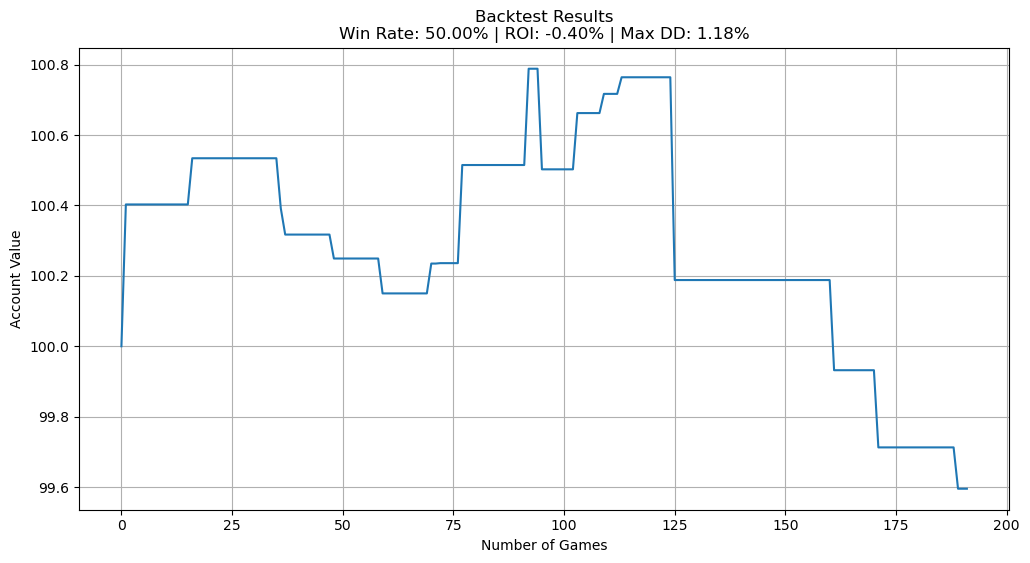

{'final_value': tensor(99.5953, dtype=torch.float64),
 'roi': tensor(-0.0040, dtype=torch.float64),
 'win_rate': 0.5,
 'max_drawdown': tensor(0.0118, dtype=torch.float64),
 'total_bets': 192}

In [11]:
# Get home/visitor team mapping
home_teams = [mlb_utils.get_team_name(home_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,3]]
visitor_teams = [mlb_utils.get_team_name(visitor_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,4]]

# Convert to torch tensor
probas_tensor = torch.from_numpy(probas)
perf_y_col_tensor = torch.from_numpy(perf_y_col)


performance_tensor = mlb_utils.custom_criterion(probas_tensor,
                                                perf_y_col_tensor,
                                                pearson_multiplier=0.0,
                                                max_bet_pct=0.1,
                                                return_res_array=True)

mlb_utils.backtest_model_custom_loss(performance_tensor,          # pre-calculated profit/loss
                                     perf_date_col,               # Reporting
                                     initial_capital=100,
                                     show_plot=True,
                                     home_teams=home_teams,       # Reporting
                                     visitor_teams=visitor_teams, # Reporting
                                     probas=probas)               # To tell which team won (reporting)
                                     

In [12]:
print(conts_train.shape)
print(y_train.shape)


(32108, 24)
(32108, 6)


## Using custom objective function & eval metric

### Objective function:

In [13]:
def sle_with_penalty(lambda_penalty=0.1):
    def sle(labels: np.ndarray, predt: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        predt: Predictions made by XGBoost (-1, 1)
        labels: Sign represents which team won (- = visitor won). Value represents the implied probability for the winning team
    
        1. Convert both predt & label to implied probability 
        1a. Define incorrect_bet_increment
        2. Apply SLE
        3. Apply similarity penalty
        4. Combine grad, hess with similarity_penalty and incorrect_bet_penalty
        """
        # print(f"labels shape: {labels.shape} predt shape: {predt.shape}")
        epsilon=1e-6
        predt_h_won = np.where(predt > 0, 1, 0)
        y_h_won = np.where(labels > 0, 1, 0)
        predt_sle = np.clip(predt, epsilon, 1-epsilon)
        predt_sle = (predt_sle + 1) / 2
        # print(predt_sle)
        
        # 1. Convert both predt & label to implied probability
        # Get sportsbook prediction (decimal odds)
        sportsbook_pred = np.abs(labels)
        # Convert XGBoost predictions (-1 to 1) to implied probability since we have sportsbook predictions.
        predt_impl = np.where(predt > 0, (predt + 1) / 2, (1 - predt) / 2) 
    
        # 1a. Define incorrect_bet_increment
        # Compare H_won. Create new array where 1 = incorrect bet, 0 otherwise
        # incorrect_bet_increment = np.where(predt_h_won == y_h_won, 1, 2)
        
        
        # 2. Apply SLE (prediction b/t 0 and 1) (note, incorrect predictions are included here and in 3)
        # SLE gradient and hessian
        sle_grad = (np.log1p(predt_sle) - np.log1p(y_h_won)) / (predt_sle + 1)
        sle_hess = ((-np.log1p(predt_sle) + np.log1p(y_h_won) + 1) / (predt_sle + 1)**2)
    
        
        # 3. Apply similarity penalty (for implied probability)
        # Penalty term: lambda / (|predt_impl - sportsbook_pred| + epsilon)
        diff = np.abs(predt_impl - sportsbook_pred)
        penalty = lambda_penalty / (diff + epsilon)
        # Gradient of penalty term: d(penalty)/d(predt)
        penalty_grad = -lambda_penalty * np.sign(predt_impl - sportsbook_pred) / (diff + epsilon)**2
        # Hessian of penalty term: d^2(penalty)/d(predt)^2
        penalty_hess = 2 * lambda_penalty / (diff + epsilon)**3
    
        # 4. Combine grad, hess with similarity_penalty and incorrect_bet_increment
        grad = sle_grad + penalty_grad #  * incorrect_bet_increment
        hess = sle_hess + penalty_hess #  * incorrect_bet_increment
    
        # print(f"Grad Shape {grad.shape} Hess: {hess.shape}")
        return grad, hess
    return sle


#### Eval metric 

In [29]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],          # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}
second_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
second_grid_search = GridSearchCV(second_model, param_grid, cv=5, verbose=1)
y_train_zero = np.clip(y_train[:,0], 0, 1)
second_grid_search.fit(conts_train, y_train_zero)
print(second_grid_search.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


In [40]:
# print(second_grid_search.best_params_)
# {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

y_train_zero = np.clip(y_train[:,0], 0, 1)

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
)

model.fit(conts_train, y_train_zero, verbose=True)


calibrated_model = CalibratedClassifierCV(model, method='isotonic') # sigmoid, isotonic
calibrated_model.fit(conts_train, y_train_zero)



# probas = model.predict_proba(perf_conts)
# print(probas)
probas = calibrated_model.predict_proba(perf_conts)

perf_y_col_copy = np.copy(perf_y_col)
probas_tensor = convert_probas(probas, perf_y_col_copy)
probas_tensor = torch.from_numpy(np.array(probas_tensor))


2025-05-07 - Pred: San Diego Padres won against New York Yankees. Correct: False 95.00086945175325 
2025-05-07 - Pred: Los Angeles Angels won against Toronto Blue Jays. Correct: True 100.14037059118922 
2025-05-07 - Pred: Cincinnati Reds won against Atlanta Braves. Correct: True 104.97363220615853 
2025-05-07 - Pred: Houston Astros won against Milwaukee Brewers. Correct: True 108.71382187010651 
2025-05-07 - Pred: San Francisco Giants won against Chicago Cubs. Correct: True 116.84107633137435 
2025-05-07 - Pred: Pittsburgh Pirates won against St. Louis Cardinals. Correct: False 110.96460165555384 
2025-05-07 - Pred: Tampa Bay Rays won against Philadelphia Phillies. Correct: False 105.59136563646226 
2025-05-07 - Pred: Arizona Diamondbacks won against New York Mets. Correct: False 100.53941452809973 
2025-05-07 - Pred: Boston Red Sox won against Texas Rangers. Correct: True 104.06523471878089 
2025-05-07 - Pred: Washington Nationals won against Cleveland Guardians. Correct: False 99.034

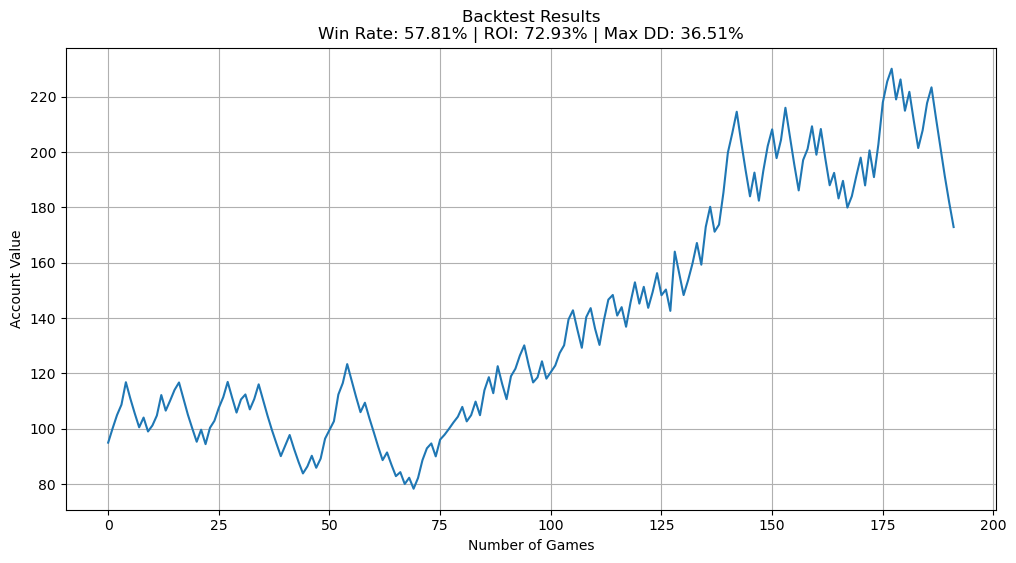

{'final_value': tensor(172.9251, dtype=torch.float64),
 'roi': tensor(0.7293, dtype=torch.float64),
 'win_rate': 0.578125,
 'max_drawdown': tensor(0.3651, dtype=torch.float64),
 'total_bets': 192}

In [41]:
# Get home/visitor team mapping
home_teams = [mlb_utils.get_team_name(home_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,3]]
visitor_teams = [mlb_utils.get_team_name(visitor_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,4]]


# probas_tensor = 1/ probas_tensor
# print(probas_tensor)
# print(perf_y_col_tensor)
# Convert to torch tensor
# probas_tensor = torch.from_numpy(probas)
perf_y_col_copy = np.copy(perf_y_col)
perf_y_col[:,0] = np.clip(perf_y_col[:,0], 0, 1)
perf_y_col_tensor = torch.from_numpy(perf_y_col_copy)


performance_tensor = mlb_utils.custom_criterion(probas_tensor,
                                      perf_y_col_tensor,
                                      pearson_multiplier=0.0,
                                      max_bet_pct=0.1,
                                      return_res_array=True)

# print(probas.type)
# probas_tensor = torch.from_numpy(probas)
mlb_utils.backtest_model_custom_loss(performance_tensor,          # pre-calculated profit/loss
                                     perf_date_col,               # Reporting
                                     initial_capital=100,
                                     show_plot=True,
                                     home_teams=home_teams,       # Reporting
                                     visitor_teams=visitor_teams, # Reporting
                                     probas=probas_tensor.numpy())               # To tell which team won (reporting)



(200, 2)

In [18]:
def custom_criterion(x, y, pearson_multiplier=0.5, max_bet_pct=0.1, return_res_array=False):
    # ------------------------------------------------
    # Preliminary calculations
    # ------------------------------------------------
    # acct_value = 100 # Preset account value
    batch_size = len(x)
    h_start_odds = y[:,1]
    v_start_odds = y[:,2]
    h_won = y[:,0]
    y_decimal_odds = torch.where(x > 0, h_start_odds, v_start_odds) # Decimal odds for model's predicted outcome
    y_prob = 1 / y_decimal_odds                  # Implied Probability (regardless of correct prediction)
    x_H_Won = torch.round(torch.sigmoid(20 * x)) # H_won for predicted bets (Converts model's -1 to 1 range to 0 to 1)
                                                 # Sigmoid so that it's differentiable. The 20 is arbitrarily large number
    y_incorrect_prediction = torch.abs((x_H_Won - h_won))          # 1 if wrong bet, otherwise 0. Used to reset kelly when wrong
    y_incorrect_prediction_mult_two = 2 * y_incorrect_prediction   # 2 if wrong bet, 0 if correct

    #x = torch.abs(x)         # OLD VERSION
    x_prob = torch.where(x > 0, (x + 1) / 2, (1 - x) / 2)
    x = x_prob                # x is now the implied probability(?) of your prediction.
                              # It's a number between 0 and 1 (formerly -1 and 1) representing the model's predicted probability of a win.
                              # This now only shows the probability. Not whether it was correct & not for which side (home vs visitor)

    
    # ------------------------------------------------
    # 1. Calculate the Pearson Correlation Coefficient
    #    Currently includes cases where predicted wrong
    #    ^ This is filtered out after step 2
    # ------------------------------------------------
    n = x.size(0)
    sum_x = torch.sum(x)
    sum_x_squared = torch.sum(x**2)
    sum_y = torch.sum(y_prob)
    sum_y_squared = torch.sum(y_prob**2)
    sum_pow_x = torch.sum(x**2)
    sum_pow_y = torch.sum(y_prob**2)
    x_mul_y = torch.mul(x, y_prob)
    sum_x_mul_y = torch.sum(x_mul_y)

    
    # PCC Formula (eps to avoid NaN)
    eps = 1e-8
    pcc_numerator = n * sum_x_mul_y - sum_x * sum_y
    pcc_denominator_one = torch.sqrt(n * sum_pow_x - sum_x_squared + eps)
    pcc_denominator_two = torch.sqrt(n * sum_pow_y - sum_y_squared + eps)
    pcc = pcc_numerator / (pcc_denominator_one * pcc_denominator_two + eps)
    pcc = pearson_multiplier * torch.abs(pcc)

    # print(x)
    print(y)
    # ------------------------------------------------
    # 2. Calculate the kelly criterion
    #    Entirely wrong predictions are negated and kept in "incorrect_bets" (pcc not applied to wrong predictions)
    #    Correct predictions are kept in "correct_bets". Pcc is applied to this & stored in pcc_adjusted_correct_bets
    #    Possible issue: This always bets max_bet_pct
    #    The result is cumulatively calculated. i.e. The sum of the previous values are used to calculate the next one
    # ------------------------------------------------
    # kelly_criterion = x - ((1 - x) / y_decimal_odds)  # OLD VERSION
    kelly_criterion = x - ((1 - x) / (y_decimal_odds - 1))
    bet_multiplier = torch.clamp(kelly_criterion, min=0)   # Kelly results that are negative are ignored
    #print(bet_multiplier)
    bet_multiplier = bet_multiplier*max_bet_pct            # Scale down the bets to the maximum allowed percentage per bet
    #print(bet_multiplier)

    # 4/5/25 adjustment of kelly
    #    Want to use cumprod. Cumsum does nothing and is the same as torch.sum in this scenario?
    #    Basically start with max_bet_pct and return as if you made the bets sequentially
    correct_bet_multiplier = bet_multiplier - (bet_multiplier * y_incorrect_prediction)          # Correct bets after kelly. Bet multiplier or 0
    if not return_res_array:
        correct_bet_multiplier = correct_bet_multiplier * (1 - pcc)                              # "correct_bet_multiplier" penalized by pcc
    assert torch.all(correct_bet_multiplier <= max_bet_pct), "Correct bet mult. can't exceed max bet pct"

    correct_bet_multiplier = correct_bet_multiplier * (y_decimal_odds - 1)                       # Bet multiplier taking market odds into account
    incorrect_bet_multiplier = bet_multiplier - (bet_multiplier * y_incorrect_prediction_mult_two) # Negative numbers are incorrect bets
    incorrect_bet_multiplier = torch.clamp(incorrect_bet_multiplier, max=0)                      # Restrict to 0 or negative
    combined_bet_multiplier = correct_bet_multiplier + incorrect_bet_multiplier                  # Combine correct & incorrect bet multipliers
    combined_bet_multiplier = combined_bet_multiplier + 1                                        # Converts to format friendly to cumprod
                                                                                                 # Ex: loss=-0.3, profit=0.3 --> loss=0.7, profit=1.3

    #print(incorrect_bet_multiplier)
    assert torch.all((x >= 0) & (x <= 1)), "Probabilities must be between 0 and 1"
    assert torch.all(y_decimal_odds > 1), "Decimal odds must be greater than 1"
    assert torch.all(kelly_criterion <= 1), "Kelly Criterion cannot be greater than 1"
    assert torch.all(incorrect_bet_multiplier >= -max_bet_pct), "Incorrect bet mult. can't exceed max bet pct"
    
    # ------------------------------------------------
    # Combine & Return
    #     Negate everything for Adam & optuna
    # ------------------------------------------------
    if return_res_array:
        return combined_bet_multiplier
        
    # Prepend max_bet_pct to the tensor before torch.cumprod
    res = torch.sum(combined_bet_multiplier) / batch_size
    # print(res)
    return -res